# Debugging OpenCL applications

Debugging OpenCL kernels is often not easy due to a lack of vendor support. However there are some tools and techniques to help, such as:

* Checking the error codes on every OpenCL function call
* Checking memory access from within kernels
* Visual inspection of outputs
* Using **printf** within kernels
* Using **Oclgrind** to check memory access violations
* Vendor-specific tools

We introduce an **bug** into our matrix multiplication kernel and see what techniques can uncover the error. In this instance we **intentionally remove** the guard check that prevents the kernel from setting values outside the domain of **C**. The size of matrices **A**, **B**, and **C** are set to (72,72) with row-major ordering. In the kernel we specify that dimension 0 of the grid maps to dimension 1 in the matrices because dimension 1 is the contiguous dimension in row-major ordering. Similarly, in the kernel we specify that dimension 1 of the grid maps to dimension 0 of the matrices.

We choose a block size of (16,4,1). Since an integer number of blocks must compose the grid in each dimension, a grid size of (80,72,1) is the smallest size that will adequately cover the matrices with (5,18,1) blocks in each dimension. This grid is then mapped to a size of (72,80) as shown in the diagram below.

<figure style="margin-left:auto; margin-right:auto; width:80%;">
    <img style="vertical-align:middle" src="../images/matrix_boundaries.svg">
    <figcaption style= "text-align:lower; margin:1em; float:bottom; vertical-align:bottom;">Running off the end of the array due to differences between array size and global size.</figcaption>
</figure>

The kernel that introduces the bug is shown below. When i1 goes beyond the limit of the matrix then it will read from off the end of matrix **B** and write off the end of matrix **C**.

```C++
// kernels_mat_mult_badmem.c source

// standard matrix multiply kernel 
__kernel void mat_mult_bug (__global float* A, 
                        __global float* B, 
                        __global float* C, 
                        unsigned int N1_A, 
                        unsigned int N0_C,
                        unsigned int N1_C) { 
            
    // C is of size (N0_C, N1_C)
    
    // i0 and i1 represent the coordinates in Matrix C 
    // We assume row-major ordering for the matrices 
    size_t i0=get_global_id(1); 
    size_t i1=get_global_id(0); 
    
    // Scratch variable
    float temp=0.0; 

    // Comment out the guard mechanism 
    // to make sure we do not go
    // outside the boundaries of matrix C 
        
    //if ((i0<N0_C) && (i1<N1_C)) {
        // Loop over columns of A and rows of B 
        for (size_t n=0; n<N1_A; n++) {
            
            // A is of size (N0_C, N1_A)
            // B is of size (N1_A, N1_C)
            
            // Loop across row i0 of A
            // and down column i1 of B
            temp+=A[i0*N1_A+n]*B[n*N1_C+i1]; 
        } 
        // Number of rows in C is same as number of rows in A
        C[i0*N1_C+i1]=temp;
    //}
} 
```

## Run the buggy application

If we try running this code then the maximum residual is often **much larger** than expected.

In [9]:
!make clean; make mat_mult_bug.exe; ./mat_mult_bug.exe

rm -rf *.exe
CC -g -fopenmp -O0 -I../include mat_mult_bug.cpp -o mat_mult_bug.exe -lOpenCL
	               name: gfx1035 
	     Device version: OpenCL 2.0  
	 global memory size: 536 MB
	    max buffer size: 456 MB
	     max local size: (1024,1024,1024)
	     max work-items: 256
Maximum error (infinity norm) is: 1.71217e+38


Note that with this OpenCL implementation the code completes without a crash, even through multiple memory access violations have taken place. Some OpenCL implementations (GPU ones in particular) do not have strict memory access violation checks. Memory access violations can then result in undefined behaviour. Due to OS security, CPU implementations are more sensitive to memory access violations than GPU implementations, where memory allocations may be padded and memory access violations are not as protected.

## Visual inspection of outputs

We load the files **array_A.dat**, **array_B.dat**, and **array_C.dat** into memory and compare results.

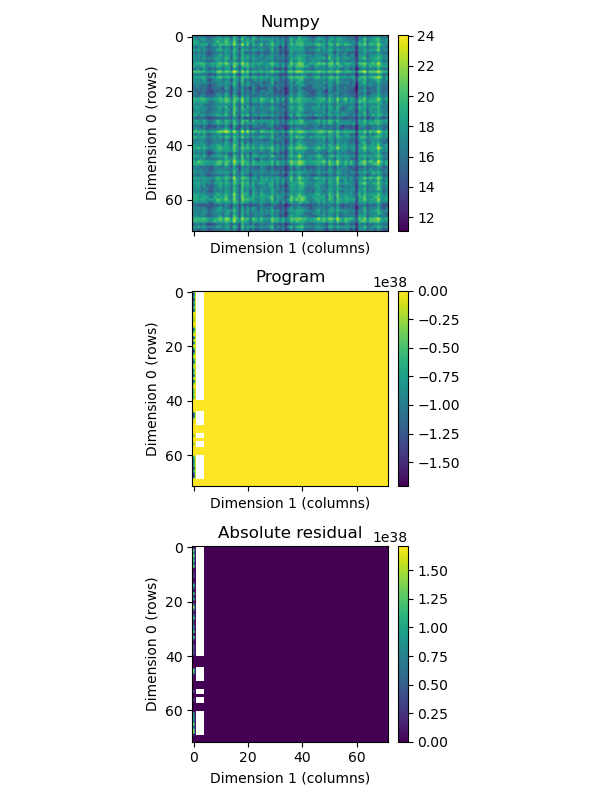

In [10]:
import os
import sys
import numpy as np
sys.path.insert(0, os.path.abspath("../include"))

import py_helper

%matplotlib widget

# Data type to use for matrices
dtype=np.float32

defines=py_helper.load_defines("mat_size.hpp")

NCOLS_A=defines["NCOLS_A"]
NROWS_C=defines["NROWS_C"]
NCOLS_C=defines["NCOLS_C"]

# A is of size (NROWS_C, NCOLS_A)
# B is of size (NCOLS_A, NCOLS_C)    
# C is of size (NROWS_C, NCOLS_C)

mat_mul=py_helper.MatMul(NCOLS_A, NROWS_C, NCOLS_C, dtype)
mat_mul.load_data()
mat_mul.check_data()

The effect of the memory error is noticeable when we perform a direct comparison between Python and our OpenCL application. Row 0 of the of the output is unaffected, however all subsequent rows are affected by the bug because for each row the kernel spills over to 8 cells of the next row. Often the numbers in the output are nonsense because we have gone outside the bounds of matrix **B** for the read, and off the bounds of matrix **C** for the last line of the write.

## Checking OpenCL calls 

Inspecting the return codes of OpenCL calls is **best practice** for programming with OpenCL. Many API errors are caught this way. In this lesson we have already checked return codes and they haven't signalled an error. We need to dig deeper....

## Checking memory access by filling with known values

When trying to get your OpenCL codes working it is helpful to first make sure that your memory accesses are valid. In the program [mat_mult_memcheck.cpp](mat_mult_memcheck.cpp) we switch out the kernel to **mat_mult_memcheck** (in the file [kernels_matmult.c](kernels_mat_mult.c)) so that it fills **C** with a **known value**. In this case we fill it with **i1**. Run the code and check the results by running the visual check above.

In [11]:
!make mat_mult_memcheck.exe; ./mat_mult_memcheck.exe

CC -g -fopenmp -O0 -I../include mat_mult_memcheck.cpp -o mat_mult_memcheck.exe -lOpenCL
	               name: gfx1035 
	     Device version: OpenCL 2.0  
	 global memory size: 536 MB
	    max buffer size: 456 MB
	     max local size: (1024,1024,1024)
	     max work-items: 256
Maximum error (infinity norm) is: 64.9658


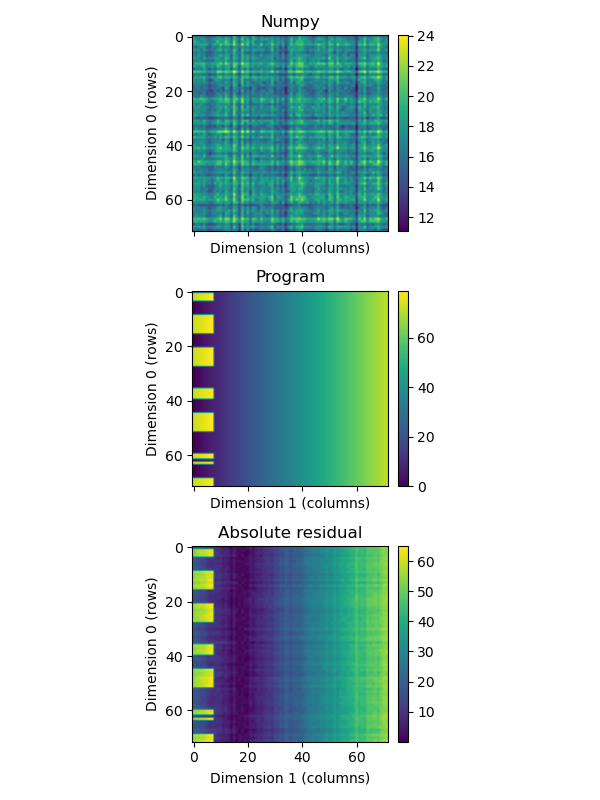

In [12]:
mat_mul.load_data()
mat_mul.check_data()

In the visual check some lines are filled with higher values of **i1** whereas others are filled with lower values. This is because in the buggy implementation **two different** kernel invocations are writing to the **same global memory location**. Also note that values have stabilised because the kernel is not using values read from outside **B**. This illustrates that one cannot rely on the order in which workgroups complete and the order in which memory updates are flushed back to global memory. Checking your memory inputs and outputs using **known** values in the kernel is a powerful **first pass** debugging technique. It is good practice to make sure your memory transfers and accesses are ok before debugging your kernel further.

## Debugging with **printf**

Most of the major OpenCL implementations support the use of a **printf** statement within a kernel. Output from printf in the kernel gets routed to standard output on the command line. In the file [mat_mult_printf.cpp](mat_mult_printf.cpp) we switch out the kernel to use **mat_mult_printf** from [kernels_mat_mult.c](kernels_mat_mult.c) which includes a printf statement that triggers whenever we exceed the size of the matrices along dimension 1.

```C
// Kernel with printf statement 
__kernel void mat_mult_printf (__global float* A, 
                        __global float* B, 
                        __global float* C, 
                        unsigned int N1_A, 
                        unsigned int N0_C,
                        unsigned int N1_C) { 
            
    // C is of size (N0_C, N1_C)
    
    // i0 and i1 represent the coordinates in Matrix C 
    // We assume row-major ordering for the matrices 
    size_t i0=get_global_id(1); 
    size_t i1=get_global_id(0); 
    
    // Scratch variable
    float temp=0.0; 

    // Comment out the guard mechanism 
    // to make sure we do not go
    // outside the boundaries of matrix C
    if ((i1>N1_C-1) && (i0==0)) {
        printf("i1 is %d\n", (int)i1);
    }
    
    //if ((i0<N0_C) && (i1<N1_C)) {
        // Loop over columns of A and rows of B 
        for (size_t n=0; n<N1_A; n++) {
            
            // A is of size (N0_C, N1_A)
            // B is of size (N1_A, N1_C)
            
            // Loop across row i0 of A
            // and down column i1 of B
            temp+=A[i0*N1_A+n]*B[n*N1_C+i1]; 
        } 
        // Number of rows in C is same as number of rows in A
        C[i0*N1_C+i1]=temp;
    //}
} 
```

Now run the program and observe that the workgroups do indeed encounter values of **i1** that go beyond the bounds of the array.

In [13]:
!make mat_mult_printf.exe; ./mat_mult_printf.exe

CC -g -fopenmp -O0 -I../include mat_mult_printf.cpp -o mat_mult_printf.exe -lOpenCL
	               name: gfx1035 
	     Device version: OpenCL 2.0  
	 global memory size: 536 MB
	    max buffer size: 456 MB
	     max local size: (1024,1024,1024)
	     max work-items: 256
i1 is 72
i1 is 73
i1 is 74
i1 is 75
i1 is 76
i1 is 77
i1 is 78
i1 is 79
Maximum error (infinity norm) is: 5.31128


## Debugging and validation with Oclgrind

[Oclgrind](https://github.com/jrprice/Oclgrind) simulates an OpenCL device that self-checks for data races, memory access violations, and erroneous API runtime calls. It currently provides an OpenCL 1.2 interface as well as **gdb-like** interactive kernel debugging. Oclgrind precisely meets the need for interactive debugging of kernels, however it is **orders of magnitude** slower than a native OpenCL application, so you need to make problem sizes really small, as we have done, or you can have a setting **-q** to just compute the first and last workgroups.

### Memory access checking

If you run **oclgrind** with the application as an argument then it intercepts OpenCL library calls that the application makes, and provides a sole OpenCL device that checks for errors. 

In [14]:
!oclgrind -q ./mat_mult_bug.exe 

	               name: Oclgrind Simulator 
	     Device version: OpenCL 1.2 (Oclgrind 21.10) 
	 global memory size: 134 MB
	    max buffer size: 134 MB
	     max local size: (1024,1024,1024)
	     max work-items: 1024

Invalid read of size 4 at global memory address 0x2000000005100
	Kernel: mat_mult_bug
	Entity: Global(72,68,0) Local(8,0,0) Group(4,17,0)
	  %1 = load float, float addrspace(1)* %arrayidx7, align 4, !dbg !59, !tbaa !49
	At line 68 (column 32) of input.cl:
	  temp+=A[i0*N1_A+n]*B[n*N1_C+i1]; 
	

Invalid read of size 4 at global memory address 0x2000000005104
	Kernel: mat_mult_bug
	Entity: Global(73,68,0) Local(9,0,0) Group(4,17,0)
	  %1 = load float, float addrspace(1)* %arrayidx7, align 4, !dbg !59, !tbaa !49
	At line 68 (column 32) of input.cl:
	  temp+=A[i0*N1_A+n]*B[n*N1_C+i1]; 
	

Invalid read of size 4 at global memory address 0x2000000005108
	Kernel: mat_mult_bug
	Entity: Global(74,68,0) Local(10,0,0) Group(4,17,0)
	  %1 = load float, float addrspace(1)* %arrayidx7,

From the error messages we have **very clear indications** that both read and write memory access violations are taking place.

### Interactive kernel debugging with **Oclgrind**

Oclgrind provides a powerful **gdb-like** debugging experience. The option **-i** allows for interactive line-by-line walkthroughs of kernels and we are going to step through each line of our buggy kernel.

* Open a terminal and run oclgrind like this
```bash
oclgrind -i ./mat_mult_bug.exe
```
It will stop at the first OpenCL encountered. Within oclgrind use the `info` command to see where the execution has stopped.
```bash
info
```
* Display all available commands using the `help` command
```bash
help
```
* The `list` command can show the source code that you are about to step through.
```bash
list
```
* Use the `next` command (and enter) a few times to step through the lines of the kernel arguments.
* The `print` command will help print out the value of the input variables **N0_C** and **N1_C**.
```bash
print N0_C
```
* Again use the `print` command to examine the value of buffer **B** at index 1. The value should be betwen 0 and 1.
```bash
print B[1]
```
* Get help on the `wi` command to change work items.
```bash
help wi
```
* Move to work item (72, 0, 0) and type **continue** until you get a memory access violation
```bash
wi 72 0 0
continue
```
* Print the value of **n**, **i0** and **i1**.
```bash
print n
print i0
print i1
```
In which array do you think the memory read access violation occurred?
* Quit the application
```bash
quit
```

### Kernel-specific debugging

Sometimes you might have one kernel to debug within a large program. If you only wish to debug a **specific kernel** without having to run the entire application there is the **oclgrind-kernel** tool. It takes in a file specifying the runtime parameters and kernel arguments, and runs that kernel using the OpenCL device simulator. As follows is the contents of [mat_mult_bug.sim](mat_mult_bug.sim):

```bash
kernels_mat_mult.c # File containing OpenCL program (can be OpenCL C or SPIR)
mat_mult_bug    # Name of the kernel to run
80 72 1     # NDRange
16 4 1      # Work-group size

# First argument 'global float *A'
# Alocation of 72*72*4 = 20736 
# bytes filled with 1's of type float
<size=20736 fill=1 float>

# Second argument 'global float *B' 
# Same size but filled with floats 
# in the range 0:5183 inclusive
<size=20736 range=0:1:5183 float>

# Third argument 'global float *C' 
# filled with zeros and type float
<size=20736 fill=0 float>

# Fourth argument integer N1_A
<size=4 uint>
72

# Fifth argument integer N0_C
<size=4 uint>
72

# Sixth argument integer N1_C
<size=4 uint>
72
```

Running the simulation then takes the form

```bash
oclgrind-kernel ./mat_mult_bug.sim
```

for memory access checks, and for interactive debugging we run

```bash
oclgrind-kernel -i ./mat_mult_bug.sim
```

and proceed with debugging as before.

## Vendor-specific tools

### NVIDIA

NVIDIA's OpenCL solution runs on NVIDIA hardware. While NVIDIA has **practically nonexistent** support for OpenCL in terms of development tools, their implemenation is mature and conformant with the latest 3.0 spec as well as having a significant number of accompanying examples. Debgugging tools for CUDA can provide insight into the processes at work on the GPU.

#### Debugging with cuda-gdb

Running the code under cuda-gdb is accompished with the command

```bash
cuda-gdb --args ./mat_mult_bug.exe -gpu
```

Debugging on the host code can proceed as per normal but I haven't found a way to access the kernel. At the time of writing this tool didn't detect the memory access violations.

#### Memory access checking with cuda-memcheck

The CUDA memory checking tool **cuda-memcheck** is designed to check for race conditions, synchronisation errors, memory initialisation problems, and memory access violations. Memory checking works for both OpenCL and CUDA applications using the following call. We need to make sure we are using the NVIDIA compute device though.

In [15]:
!cuda-memcheck ./mat_mult_bug.exe -gpu 1

========= CUDA-MEMCHECK
========= This tool is deprecated and will be removed in a future release of the CUDA toolkit
========= Please use the compute-sanitizer tool as a drop-in replacement
	               name: NVIDIA GeForce RTX 3060 Laptop GPU 
	     Device version: OpenCL 3.0 CUDA 
	 global memory size: 6226 MB
	    max buffer size: 1556 MB
	     max local size: (1024,1024,64)
	     max work-items: 1024
Maximum error (infinity norm) is: 5.31128
========= ERROR SUMMARY: 0 errors


We see that cuda-memcheck is catching the memory access error, but we don't have an in-depth look at what is happening in the kernel. Unfortunately the tool **cuda-memcheck** will soon be replaced by **compute-sanitizer**, however that application does not seem to support OpenCL.

In [17]:
!compute-sanitizer --tool memcheck --padding 0 --target-processes all ./mat_mult_bug.exe -gpu 1

========= COMPUTE-SANITIZER
	               name: NVIDIA GeForce RTX 3060 Laptop GPU 
	     Device version: OpenCL 3.0 CUDA 
	 global memory size: 6226 MB
	    max buffer size: 1556 MB
	     max local size: (1024,1024,64)
	     max work-items: 1024
Maximum error (infinity norm) is: 5.31128
========= Error: Target application terminated before first instrumented API call


### AMD

AMD has the **rocgdb** debugger available. 

```bash
rocgdb --args ./mat_mult_bug.exe -gpu 0
```

We set a breakpoint in the **mat_mult** kernel by typing this at the gdb command line

```gdb
b mat_mult_bug
run
```

This is currently limited in usefulness until we can find a way to get the source code loaded and print kernel variables.

### Intel

The [OneAPI toolkit](https://www.intel.com/content/www/us/en/developer/tools/oneapi/toolkits.html#base-kit) has an enhanced GDB debugger that has the ability to step through and debug OpenCL kernels. It works with the [Intel OpenCL runtime](https://www.intel.com/content/www/us/en/developer/articles/tool/opencl-drivers.html#cpu-section). Incidentally, the standard **GDB** debugger also works to debug kernels on the Intel OpenCL CPU runtime.

#### Debugging with GDB

In order to enable kernel debugging we need to select the CPU device from the Intel OpenCL implementation and set the following kernel compilation options when the OpenCL Program is compiled, like this:

```C++
    // Turn this source code into a program
    cl_program program = h_build_program(
        kernel_source, 
        context, 
        device,
        // Put debugging information here
        // -g and -s flags are Intel-specifc
        "-g -s kernels_mat_mult.c -cl-opt-disable"
    );
```

The `-s` flag is to tell the runtime where the kernel source is, the `-g` is to enable debugging symbols and the `-cl-opt-disable` flag disables OpenCL optimisations. We set these options in the source file [mat_mult_bug_gdb.cpp](mat_mult_bug_gdb.cpp) as an additional argument to the **h_build_program** helper function.

Then we can run **gdb-oneapi** if you have the OneAPI toolkit (or just **gdb** if you don't) to start the program

```bash
gdb-oneapi --args ./mat_mult_bug_gdb.exe -cpu 0
```

Within the kernel there are three variables we can use to specify a breakpoint.

* __ocl_dbg_gid0
* __ocl_dbg_gid1
* __ocl_dbg_gid2

They represent the global id for dimensions 1, 2, and 3 during kernel execution. We can use these at gdb command line to set a specific breakpoint in the kernel. In this case we set execution to halt with when a kernel with **(__ocl_dbg_gid0 == 72) and (__ocl_dbg_gid1 == 0)** executes. 

```bash
break mat_mult_bug if (__ocl_dbg_gid0 == 72) && (__ocl_dbg_gid1 == 0)
```

Ignore the warning about shared library loading. The kernel source code is yet to be loaded. Now run the code

```bash
run
```

and it should stop at the correct work-item. We now have all the same debugging commands available as with Oclgrind and even new abilities such as being able to set variables.

```bash
set temp=0
```

Now enter 

```bash
quit
```

to exit the program. I noticed that the Intel implementation didn't detect the memory error as a memory access violation.

<address>
Written by Dr. Toby Potter of <a href="https://www.pelagos-consulting.com">Pelagos Consulting and Education</a> for the <a href="https://pawsey.org.au">Pawsey Supercomputing Research Centre</a>. All trademarks mentioned are the property of their respective owners.
</address>